In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error , r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("monster_com-job_sample.csv")
df.head()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
0,United States of America,US,NaN,No,jobs.monster.com,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,Full Time Employee,"Madison, WI 53702",NaN,http://jobview.monster.com/it-support-technici...,NaN,IT/Software Development,11d599f229a80023d2f40e7c52cd941e
1,United States of America,US,NaN,No,jobs.monster.com,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,Full Time,"Madison, WI 53708",Printing and Publishing,http://jobview.monster.com/business-reporter-e...,NaN,NaN,e4cbb126dabf22159aff90223243ff2a
2,United States of America,US,NaN,No,jobs.monster.com,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,"Full Time, Employee",DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,http://jobview.monster.com/senior-training-lea...,NaN,NaN,839106b353877fa3d896ffb9c1fe01c0
3,United States of America,US,NaN,No,jobs.monster.com,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,Full Time,"Dixon, CA",Altec Industries,http://jobview.monster.com/engineer-quality-jo...,NaN,Experienced (Non-Manager),58435fcab804439efdcaa7ecca0fd783
4,United States of America,US,NaN,No,jobs.monster.com,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,Full Time Employee,"Camphill, PA",Retail,http://jobview.monster.com/shift-supervisor-pa...,NaN,Project/Program Management,64d0272dc8496abfd9523a8df63c184c


In [3]:
df.dtypes

country            object
country_code       object
date_added         object
has_expired        object
job_board          object
job_description    object
job_title          object
job_type           object
location           object
organization       object
page_url           object
salary             object
sector             object
uniq_id            object
dtype: object

In [4]:
df.describe()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
count,22000,22000,122,22000,22000,22000,22000,20372,22000,15133,22000,3446,16806,22000
unique,1,1,78,1,1,18744,18759,39,8423,738,22000,1737,163,22000
top,United States of America,US,9/22/2016,No,jobs.monster.com,12N Horizontal Construction Engineers Job Desc...,Monster,Full Time,"Dallas, TX",Healthcare Services,http://jobview.monster.com/it-support-technici...,"40,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),11d599f229a80023d2f40e7c52cd941e
freq,22000,22000,6,22000,22000,104,318,6757,646,1919,1,50,4594,1


In [5]:
df.isna().sum()


country                0
country_code           0
date_added         21878
has_expired            0
job_board              0
job_description        0
job_title              0
job_type            1628
location               0
organization        6867
page_url               0
salary             18554
sector              5194
uniq_id                0
dtype: int64

In [6]:
df.dropna(subset=['job_title','salary', 'sector', 'location'], inplace=True)



In [7]:
df.isna().sum()


country               0
country_code          0
date_added         2607
has_expired           0
job_board             0
job_description       0
job_title             0
job_type             18
location              0
organization        681
page_url              0
salary                0
sector                0
uniq_id               0
dtype: int64

Work on converting data columns to easily navigate and investigate the data

Location

In [8]:
locations = df['location']
state_location = []
for x in range(len(locations)):
        
        if locations.get(x) != None:
                location = locations.get(x)
                location = str(location)
                area = location.split(',')
                state = area[len(area)-1]
                print(state)
                if(state[1:3].isupper()):
                        state_location.append(state[1:3])
                else:
                        state_location.append('N/A')
        else:
                state_location.append('N/A')

 TX 77098
 TX
 IA 51510
 Manufacturing
 IL 60502
 Field Service
 WV
 CO 80237
 CA 94551
 TX
 NJ 07712
 CO 80216
 PA 18017
 TX 77040
 CO
 TX 77002
 CA 95811
 OH 44092
 FL
 CO
Telecommute
 TX
 CO 80202
 CO 80112
 OH 44515
 TX
 IN 46706
 TX
 FL
 CO 80202
 CO 80112
 PA
 CO 80237
 CO 80203
 CO 80202
Packaging Engineer
 CA
 MN 55344
 OH 45220
 Team Leader Restaurant Job)
 MN 55403
 NV 89119
 NV 89144
 CA 92618
 NV 89119
 NV 89119
 CA 92122
 MA 02111
 MI 49546
 FL
 MA
 MI 49546
 TX 79603
 NJ
 FL 32826
 DE
 KY 40404
 CA 94601
 MA 02108
 NY 10007
 VA 22151
 TX
 MD 21045
 FL 33701
Part Time Deputy Judicial Marshal - Belfast
 TX
 TX
 TX
 NJ
 OH 44134
 FL 32905
 CO 80112
 TX
 TX
 TX
 FL 32920
 TX
 MN
 TX
 TX
 DE
 TX
 CO 80014
 TX
 NY 10007
 WA
 TX
 MA 01803
 TX
 CO 80111
 IN 46225
 TX
 CO 80014
 IA 52404
 TX 76011
 FL 33173
 TX
 CO 80238
 TX
 TX
 CO
 TX
 TX
 TX
 CO 80238
 CO 80010
 OH 44310
 TX
 CA 96001
 TN
 MO
 FL 33601
 IA 51106
 NJ
 TX
 TN
 TX
 TN 38105
 SC 29208
 TX
 WI 54650
 SC
 TX 78249
Ad

In [9]:
df['state']= state_location

In [10]:
df['state'].unique()

array(['N/A', 'TX', 'IA', 'IL', 'WV', 'CO', 'CA', 'NJ', 'PA', 'OH', 'FL',
       'IN', 'MN', 'NV', 'MA', 'MI', 'DE', 'KY', 'NY', 'VA', 'MD', 'WA',
       'TN', 'MO', 'SC', 'WI', 'NC', 'GA', 'ON', 'AL', 'WY', 'KS', 'NM'],
      dtype=object)

In [11]:
state_regions = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West Coast',
    'CO': 'West', 'CT': 'Northeast', 'DE': 'South', 'FL': 'South', 'GA': 'South',
    'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'KY': 'South', 'LA': 'South', 'ME': 'Northeast', 'MD': 'South',
    'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South', 'MO': 'Midwest',
    'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast',
    'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest',
    'OK': 'South', 'OR': 'West Coast', 'PA': 'Northeast', 'RI': 'Northeast',
    'SC': 'South', 'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West',
    'VT': 'Northeast', 'VA': 'South', 'WA': 'West Coast', 'WV': 'South',
    'WI': 'Midwest', 'WY': 'West', 'DC': 'Northeast'
}

In [12]:
# Strip whitespace and make uppercase just in case
import re

# Extract the 2-letter state abbreviation using regex
df['state'] = df['location'].str.extract(r',\s*([A-Z]{2})\s*\d{0,5}')


# Map states to regions
df['region'] = df['state'].map(state_regions)

In [13]:
df.head()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id,state,region
13,United States of America,US,NaN,No,jobs.monster.com,Launch your teaching career with the Leader in...,Primrose Private Preschool Teacher Job in Houston,Full Time,"Houston, TX 77098",Education,http://jobview.monster.com/Primrose-Private-Pr...,9.00 - 13.00 $ /hour,Entry Level,b43c077756d5a326c4854e1399fd2464,TX,South
14,United States of America,US,NaN,No,jobs.monster.com,Construction Professional For more than 15 yea...,Superintendent Job in Houston,Full Time Employee,"Houston, TX",Construction - Industrial Facilities and Infra...,http://jobview.monster.com/Superintendent-Job-...,"80,000.00 - 95,000.00 $ /year",Building Construction/Skilled Trades,d8491fcefe14d1398de419984dccf427,TX,South
19,United States of America,US,NaN,No,jobs.monster.com,"Competitive compensation package, excellent co...",Technician - Robot & Multi-Axis CNC Field Serv...,Full Time,"Carter Lake, IA 51510",NaN,http://jobview.monster.com/Technician-Robot-Mu...,"60,000.00 - 72,000.00 $ /year",Experienced (Non-Manager),3bef462fc38d743c7fbce17cf50ee7d5,IA,Midwest
29,United States of America,US,NaN,No,jobs.monster.com,Experis is working with a Pharmaceutical start...,Sr. Process Engineer,Full Time Employee,"Sr. Process Engineer, Manufacturing","Chicago, IL",http://jobview.monster.com/Sr-Process-Engineer...,"70,000.00 - 100,000.00 $ /year",Engineering,779bb4c9bf038b7fb775134736d36fd4,NaN,NaN
32,United States of America,US,NaN,No,jobs.monster.com,Seeking individual with 5+ years experience de...,Machine Control Systems Engineer - BSEE Job in...,Full Time,"Aurora, IL 60502",NaN,http://jobview.monster.com/Machine-Control-Sys...,"75,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),7acc0ab84a0d47b6a704a827973df111,IL,Midwest


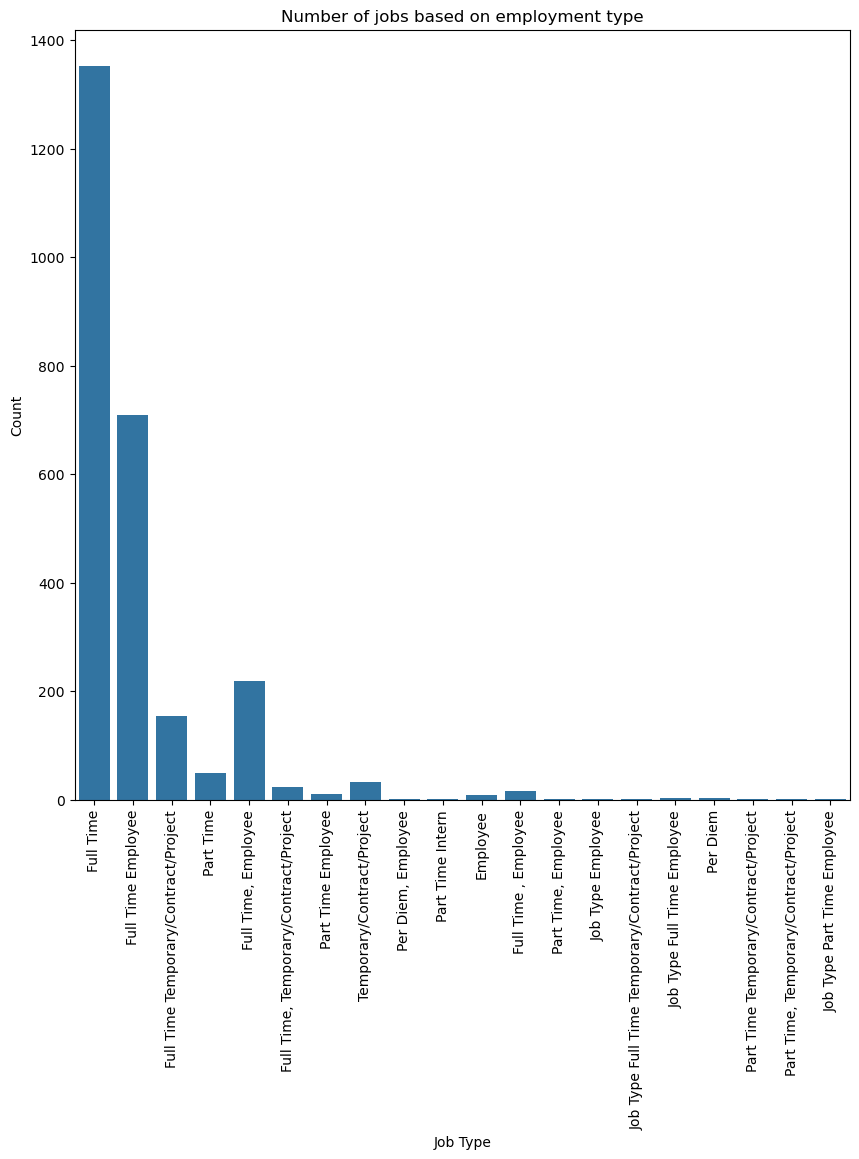

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(x='job_type', data=df)
plt.title('Number of jobs based on employment type')
plt.xlabel('Job Type')
plt.xticks(rotation=90)
plt.ylabel('Count')

plt.show()

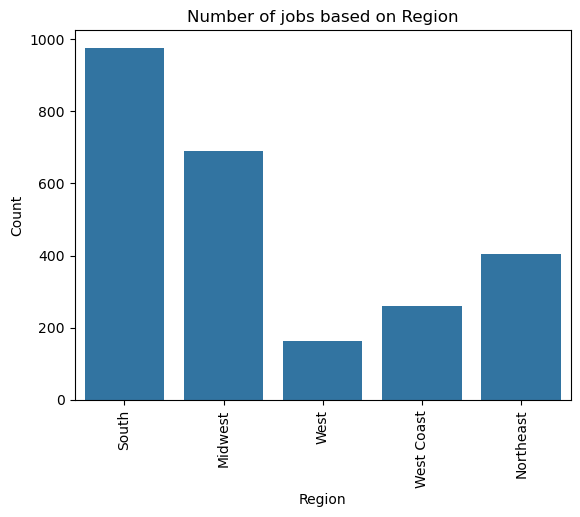

In [15]:
plt.figure()
sns.countplot(x='region', data=df )
plt.title('Number of jobs based on Region')
plt.xlabel('Region')
plt.xticks(rotation=90)
plt.ylabel('Count')

plt.show()

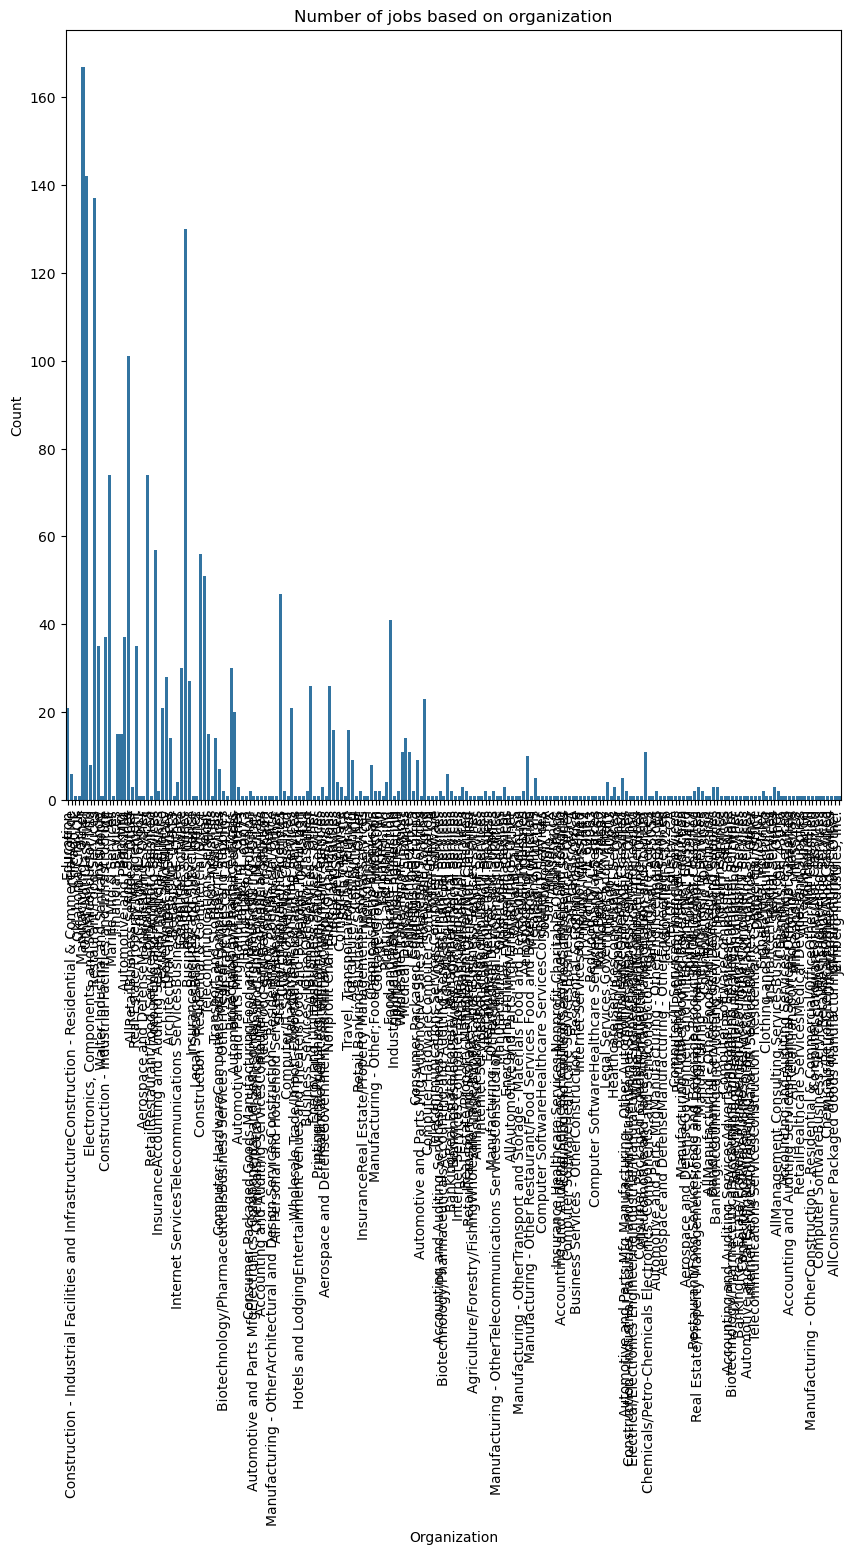

In [16]:

plt.figure(figsize=(10,10))
sns.countplot(x='organization', data=df)
plt.title('Number of jobs based on organization')
plt.xlabel('Organization')
plt.xticks(rotation=90)
plt.ylabel('Count')

plt.show()

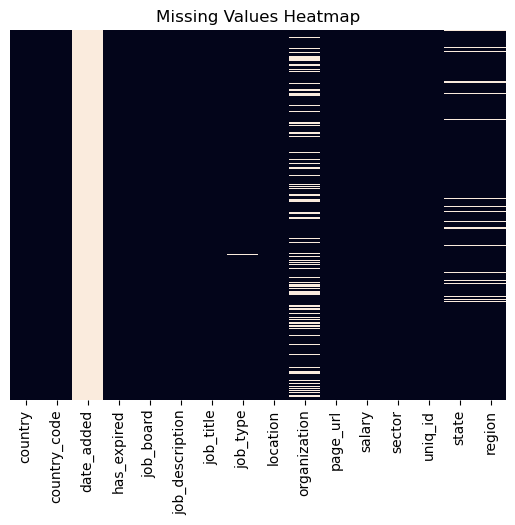

In [17]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


Working with Salary

In [18]:
# Helper function to parse salary
def parse_salary(s):
    if pd.isna(s) or 'Not Specified' in s:
        return pd.Series([None, None, None])
    
    # Remove commas and dollar signs
    s_clean = s.replace(',', '').replace('$', '')
    
    # Match patterns like "50000 - 70000", "9.00 - 13.00", "60000/year"
    match = re.findall(r'(\d+(?:\.\d+)?)', s_clean)
    
    if len(match) == 1:
        min_sal = max_sal = float(match[0])
    elif len(match) >= 2:
        min_sal, max_sal = float(match[0]), float(match[1])
    else:
        return pd.Series([None, None, None])
    
    # Detect if it's hourly/monthly/yearly
    if 'hour' in s.lower():
        period = 'hour'
    elif 'month' in s.lower():
        period = 'month'
    else:
        period = 'year'
        
    return pd.Series([min_sal, max_sal, period])


In [19]:
salary = df['salary'].apply(parse_salary)

In [20]:
print(salary)

             0         1     2
13         9.0      13.0  hour
14     80000.0   95000.0  year
19     60000.0   72000.0  year
29     70000.0  100000.0  year
32     75000.0  100000.0  year
...        ...       ...   ...
21985      NaN       NaN  None
21987  80000.0   80000.0  year
21996  45000.0   60000.0  year
21998     25.0      28.0  hour
21999  40000.0   46000.0  year

[2612 rows x 3 columns]


In [21]:
df['salary_min'] = salary[0]
df['salary_max'] = salary[1]
df['salary_means'] = salary[2]

In [22]:
df.head()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id,state,region,salary_min,salary_max,salary_means
13,United States of America,US,NaN,No,jobs.monster.com,Launch your teaching career with the Leader in...,Primrose Private Preschool Teacher Job in Houston,Full Time,"Houston, TX 77098",Education,http://jobview.monster.com/Primrose-Private-Pr...,9.00 - 13.00 $ /hour,Entry Level,b43c077756d5a326c4854e1399fd2464,TX,South,9.0,13.0,hour
14,United States of America,US,NaN,No,jobs.monster.com,Construction Professional For more than 15 yea...,Superintendent Job in Houston,Full Time Employee,"Houston, TX",Construction - Industrial Facilities and Infra...,http://jobview.monster.com/Superintendent-Job-...,"80,000.00 - 95,000.00 $ /year",Building Construction/Skilled Trades,d8491fcefe14d1398de419984dccf427,TX,South,80000.0,95000.0,year
19,United States of America,US,NaN,No,jobs.monster.com,"Competitive compensation package, excellent co...",Technician - Robot & Multi-Axis CNC Field Serv...,Full Time,"Carter Lake, IA 51510",NaN,http://jobview.monster.com/Technician-Robot-Mu...,"60,000.00 - 72,000.00 $ /year",Experienced (Non-Manager),3bef462fc38d743c7fbce17cf50ee7d5,IA,Midwest,60000.0,72000.0,year
29,United States of America,US,NaN,No,jobs.monster.com,Experis is working with a Pharmaceutical start...,Sr. Process Engineer,Full Time Employee,"Sr. Process Engineer, Manufacturing","Chicago, IL",http://jobview.monster.com/Sr-Process-Engineer...,"70,000.00 - 100,000.00 $ /year",Engineering,779bb4c9bf038b7fb775134736d36fd4,NaN,NaN,70000.0,100000.0,year
32,United States of America,US,NaN,No,jobs.monster.com,Seeking individual with 5+ years experience de...,Machine Control Systems Engineer - BSEE Job in...,Full Time,"Aurora, IL 60502",NaN,http://jobview.monster.com/Machine-Control-Sys...,"75,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),7acc0ab84a0d47b6a704a827973df111,IL,Midwest,75000.0,100000.0,year


In [23]:
def normalize_salary(row):
    if row['salary_means'] == 'hour':
        return row['salary_min'] * 2080, row['salary_max'] * 2080
    elif row['salary_means'] == 'month':
        return row['salary_min'] * 12, row['salary_max'] * 12
    else:
        return row['salary_min'], row['salary_max']



In [24]:
df[['min_salary_yearly', 'max_salary_yearly']] = df.apply(normalize_salary, axis=1, result_type='expand')

In [25]:
df['salary_bin'] = df['max_salary_yearly'] // 5000 * 5000  # bucket into $5k bins


In [26]:
salary_counts = df['salary_bin'].value_counts().sort_index()
top_bins = salary_counts.head(10)


C:\Users\Paul Tuccinardi\AppData\Local\Temp\ipykernel_18424\3293628505.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_bins.index.astype(int), y=top_bins.values, palette='viridis')


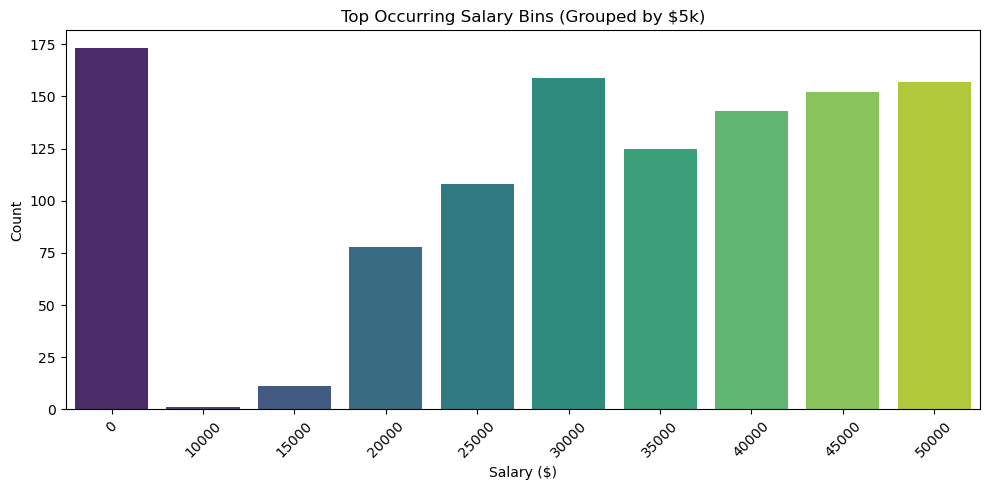

In [27]:
plt.figure(figsize=(10, 5))
sns.barplot(x=top_bins.index.astype(int), y=top_bins.values, palette='viridis')
plt.title("Top Occurring Salary Bins (Grouped by $5k)")
plt.xlabel("Salary ($)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Paul Tuccinardi\AppData\Local\Temp\ipykernel_18424\1747054880.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_salaries.values, y=top_salaries.index, palette="Blues_d")


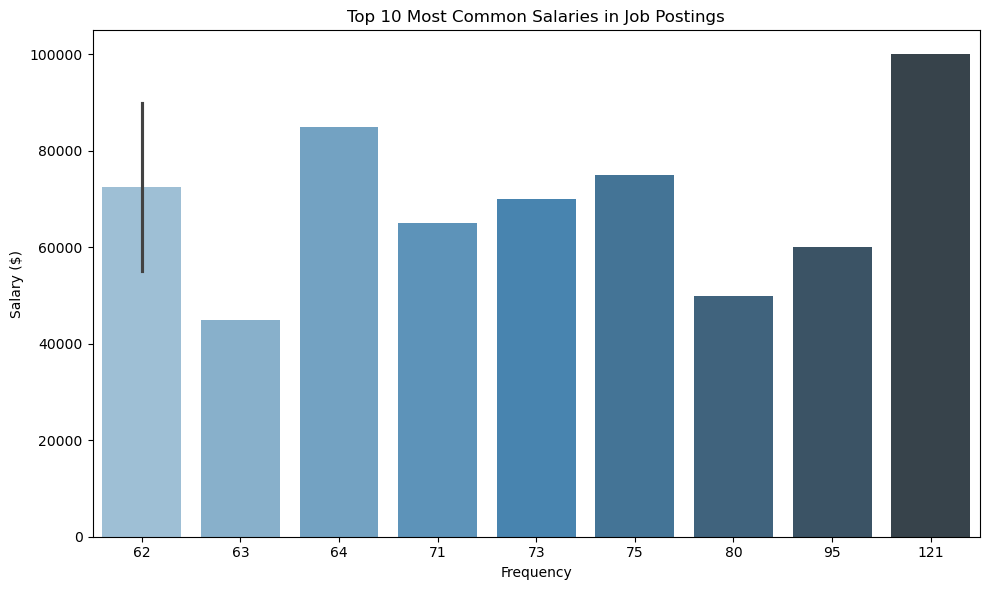

In [28]:
top_salaries = df['max_salary_yearly'].value_counts().nlargest(10)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_salaries.values, y=top_salaries.index, palette="Blues_d")
plt.xlabel("Frequency")
plt.ylabel("Salary ($)")
plt.title("Top 10 Most Common Salaries in Job Postings")
plt.tight_layout()
plt.show()

C:\Users\Paul Tuccinardi\AppData\Local\Temp\ipykernel_18424\173240465.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lowest_salaries, x='avg_salary', y='job_title', palette='Reds')


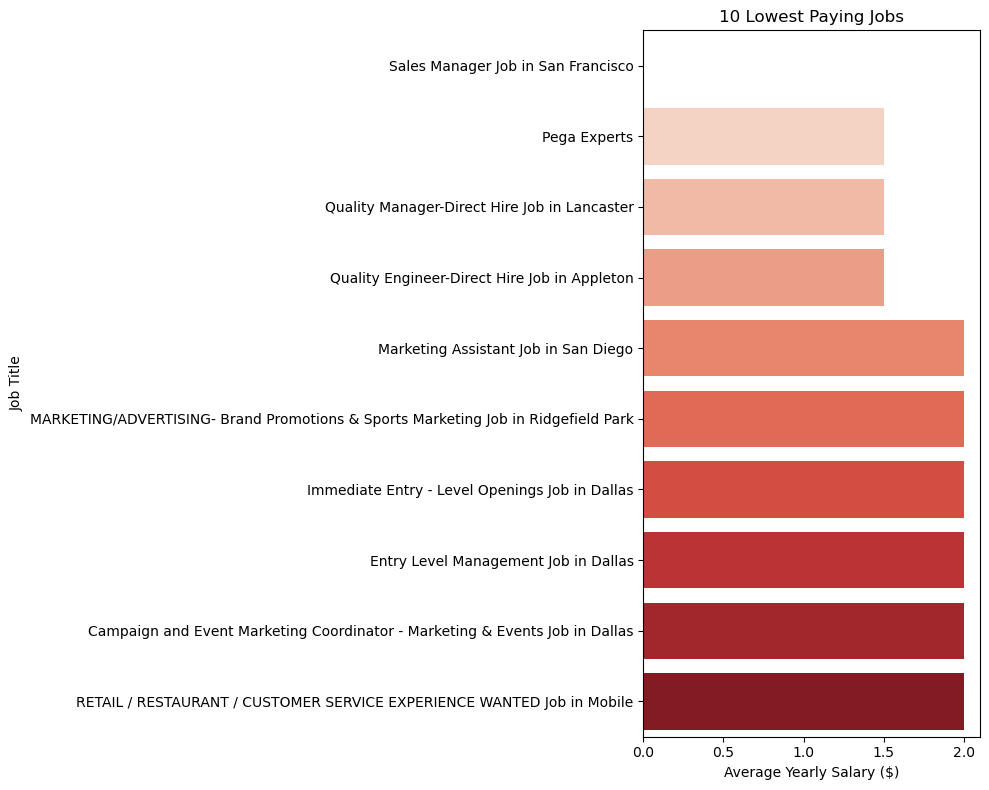

In [29]:

# Step 1: Compute average salary for each job
df['avg_salary'] = df[['min_salary_yearly', 'max_salary_yearly']].mean(axis=1)

# Step 2: Drop rows where avg_salary is missing
df_salary_clean = df.dropna(subset=['avg_salary'])

# Step 3: Get 10 lowest average salaries
lowest_salaries = df_salary_clean.nsmallest(10, 'avg_salary')

# Step 4: Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=lowest_salaries, x='avg_salary', y='job_title', palette='Reds')
plt.xlabel("Average Yearly Salary ($)")
plt.ylabel("Job Title")
plt.title("10 Lowest Paying Jobs")
plt.tight_layout()
plt.show()


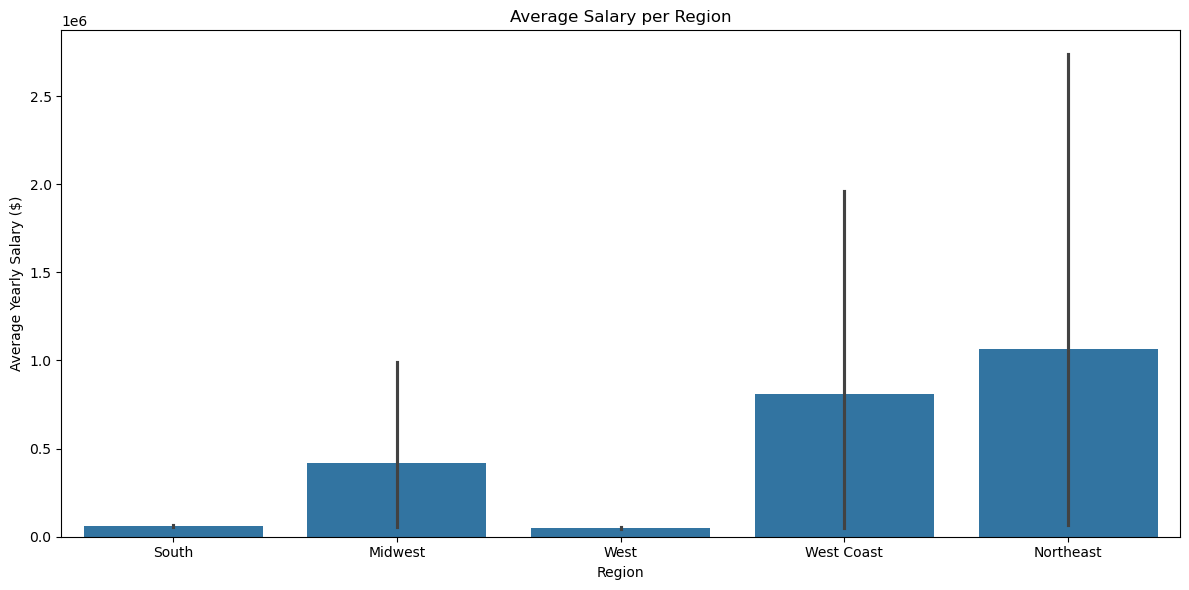

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='region', y='avg_salary')
plt.xlabel("Region")
plt.ylabel("Average Yearly Salary ($)")
plt.title("Average Salary per Region")
plt.tight_layout()
plt.show()

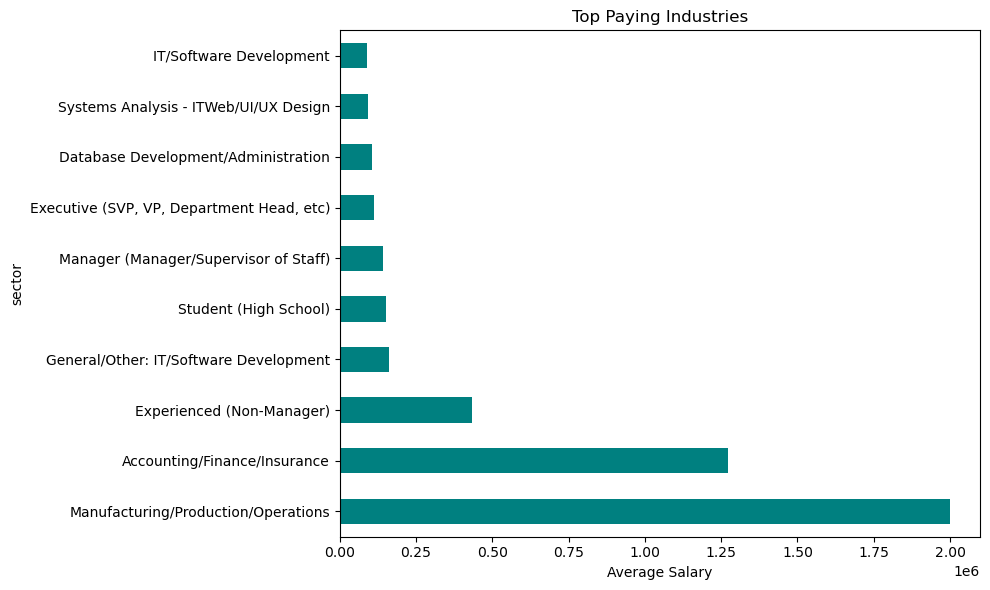

In [31]:
top_industries = df.groupby('sector')['avg_salary'].mean().sort_values(ascending=False).head(10)
top_industries.plot(kind='barh', figsize=(10,6), color='teal')
plt.title("Top Paying Industries")
plt.xlabel("Average Salary")
plt.tight_layout()
plt.show()

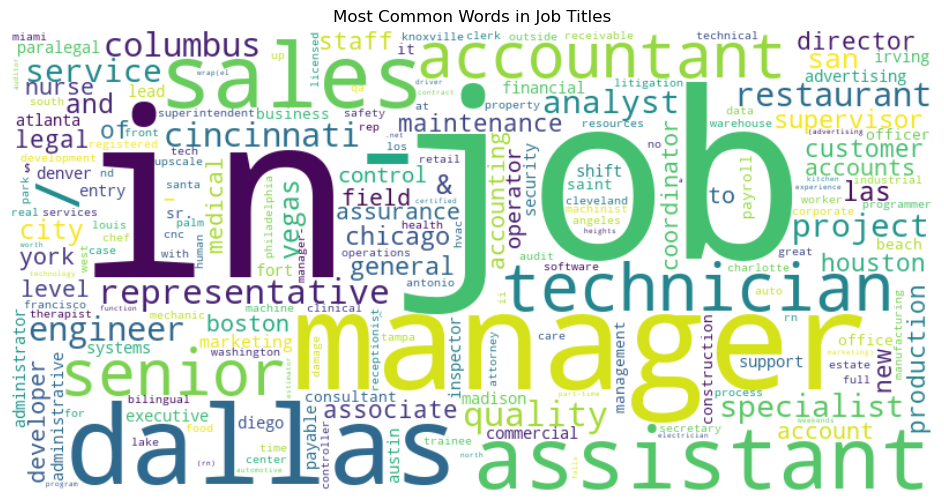

In [32]:


word_freq = Counter(" ".join(df['job_title'].dropna()).lower().split())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Job Titles")
plt.show()

In [33]:
df['salary_range'] = df['max_salary_yearly'] - df['min_salary_yearly']
#df = pd.get_dummies(df, columns=['sector'], prefix='cat')


In [34]:
#df = pd.get_dummies(df, columns=['region'], prefix='region')


In [35]:
experience_mapping = {'Entry Level': 0, 'Mid Level': 1, 'Senior Level': 2}
df['experience_level_encoded'] = df['sector'].map(experience_mapping)


In [36]:
df['is_engineer'] = df['job_title'].str.contains('engineer', case=False, na=False).astype(int)
df['is_manager'] = df['job_title'].str.contains('manager', case=False, na=False).astype(int)


In [37]:


# Select numeric features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Focus on correlation with avg_salary
salary_corr = correlation_matrix['avg_salary'].sort_values(ascending=False)

# Display top 10 most correlated features
print(salary_corr.head(10))


avg_salary                  1.000000
max_salary_yearly           0.995472
salary_bin                  0.995472
min_salary_yearly           0.992958
salary_range                0.722551
salary_min                  0.030576
salary_max                  0.026084
experience_level_encoded         NaN
Name: avg_salary, dtype: float64


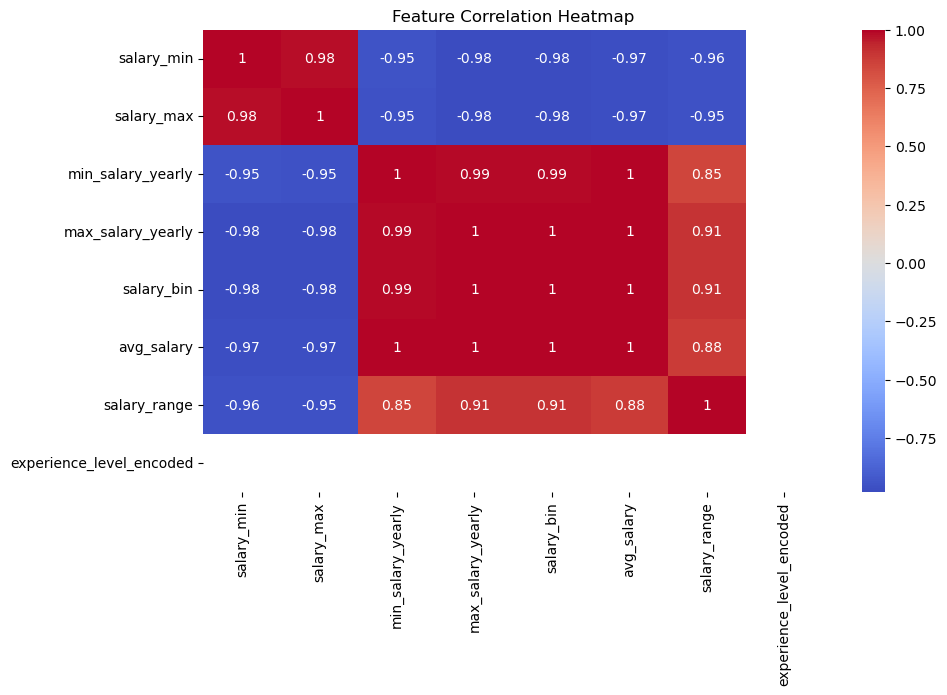

In [38]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [39]:
df = df.drop(columns = {'experience_level_encoded','salary_bin'})

In [40]:
high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]  # Exclude self-correlation
print(high_corr_pairs[high_corr_pairs > 0.95])  # Adjust threshold as needed


max_salary_yearly  salary_bin           1.000000
salary_bin         max_salary_yearly    1.000000
avg_salary         max_salary_yearly    0.995472
max_salary_yearly  avg_salary           0.995472
avg_salary         salary_bin           0.995472
salary_bin         avg_salary           0.995472
avg_salary         min_salary_yearly    0.992958
min_salary_yearly  avg_salary           0.992958
                   max_salary_yearly    0.977201
max_salary_yearly  min_salary_yearly    0.977201
salary_bin         min_salary_yearly    0.977201
min_salary_yearly  salary_bin           0.977201
dtype: float64


# Model Creation

In [55]:
df_model = df.copy().dropna()
X = df_model.drop('avg_salary', axis=1)
y = df_model['avg_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Separate feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [57]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['salary_min', 'salary_max', 'min_salary_yearly', 'max_salary_yearly',
       'salary_range'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['country', 'country_code', 'date_added', 'has_expired', 'job_board',
       'job_description', 'job_title', 'job_type', 'location', 'organization',
       'page_url', 'salary', 'sector', 'uniq_id', 'state', 'region',
       'salary_means'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [58]:
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 3499.5750000000007
RMSE: 3499.5750000000007
R2 Score: nan


c:\Users\Paul Tuccinardi\anaconda3\envs\DataScience\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [67]:
# Ensure you're working with the trained pipeline that includes a tree-based regressor  # Make sure this was fitted earlier

# Check if the model has feature_importances_ (e.g. RandomForest or GradientBoosting)
if hasattr(model.named_steps['regressor'], 'feature_importances_'):
    importances = model.named_steps['regressor'].feature_importances_

    # Get transformed feature names (numeric + encoded categorical)
    categorical_encoder = model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder']
    categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_features)

    # Combine with numeric feature names
    all_features = list(numeric_features) + list(categorical_feature_names)

    # Create DataFrame and plot
    importance_df = pd.DataFrame({
        'feature': all_features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(15), x='importance', y='feature')
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
else:
    print("Selected model does not support feature importances.")


AttributeError: 'GradientBoostingRegressor' object has no attribute 'named_steps'

In [60]:
X = df_model.drop('avg_salary', axis=1)
y = df_model['avg_salary']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [61]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}


In [62]:
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X, y)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    
    results.append({
        'Model': name,
        'MAE (5-fold CV)': round(mae, 2)
    })

results_df = pd.DataFrame(results).sort_values(by='MAE (5-fold CV)')


In [63]:
print(results_df)

               Model  MAE (5-fold CV)
3      Decision Tree          9556.50
5  Gradient Boosting          9675.14
4      Random Forest         10172.64
1   Ridge Regression         11817.46
0  Linear Regression         11828.08
2   Lasso Regression         35767.67
